In [14]:
import numpy as np
from ecephys import xrsig
from findlay2025a import spindles as sp
from findlay2025a import core, hypnograms
from findlay2025a.constants import Experiments, Files
import wisc_ecephys_tools as wet

In [15]:
sglx_subject = wet.get_sglx_subject("CNPIX4-Doppio")
experiment = Experiments.NOD

In [7]:
s3 = wet.get_sglx_project("shared")
nb = wet.get_sglx_project("seahorse")

estm_start, estm_end = core.get_estimation_bounds(sglx_subject, experiment)
hg = (
    hypnograms.load_statistical_condition_hypnograms(
        experiment, sglx_subject.name, include_full_conservative=True
    )
    .pop("full_conservative")
    .drop_states(core.ARTIFACT_STATES + ["NoData"])
)
params = sp.get_spindle_detection_params()

lf_cx = core.open_cortical_lfps(sglx_subject.name, experiment)

/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:87: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 128069. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)
/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:87: UserWarning: The specified chunks separate the stored chunks along dimension "channel" starting at index 262. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)


In [4]:
q = 5
lf_cx = xrsig.decimate_timeseries(lf_cx, q)

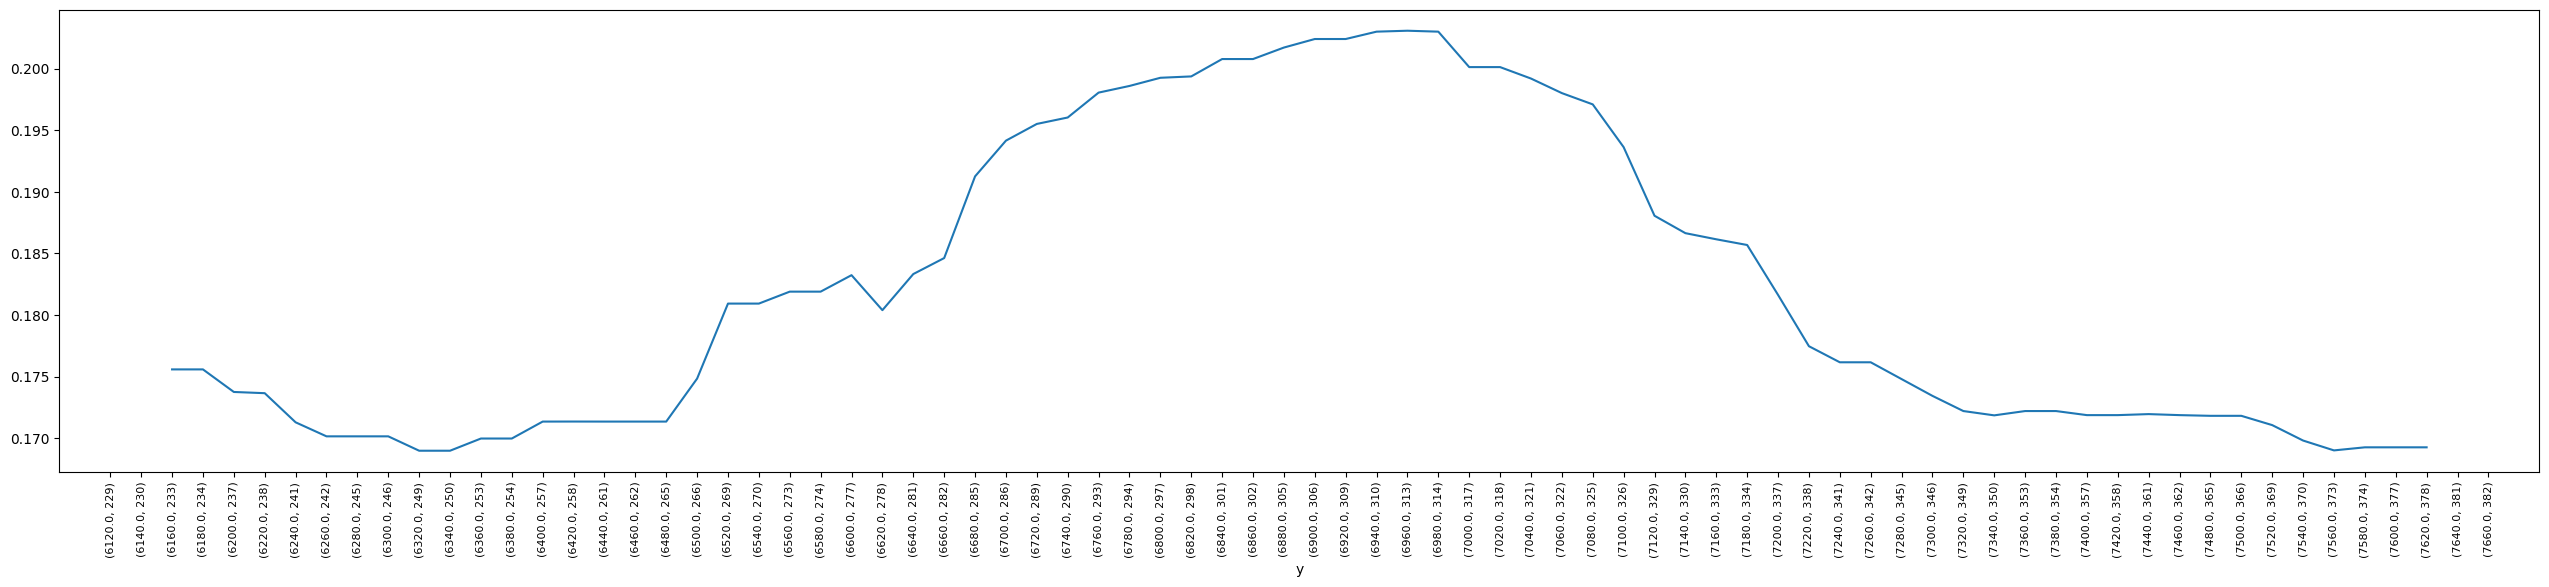

In [ ]:
cx_chan = sp.select_best_spindle_channel(
    lf_cx,
    estm_start,
    estm_end,
    params["sigma_lo"],
    params["sigma_hi"],
    params["broadband_lo"],
    params["broadband_hi"],
)

# Get cortical spindles

In [ ]:
cx_chan_lf = lf_cx.sel(channel=[cx_chan]).load()
(
    cx_lf_sigma,
    cx_lf_broad,
    cx_rpow,
    cx_mrms,
    cx_mrms_thresh,
    cx_mcorr,
    cx_decision_function,
    cx_spindles,
    cx_troughs,
) = sp.detect_single_channel_spindles(cx_chan_lf, params, hg)
print(
    f"Cortical NREM spindle rate: {(cx_spindles['Stage'] == 'NREM').sum() / hg.keep_states(['NREM']).duration.sum()} Hz"
)

Setting up band-pass filter from 9 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 8.25 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 16.75 Hz)
- Filter length: 277 samples (2.216 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 827 samples (6.616 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Cortical NREM spindle rate: 0.07712369891268171 Hz


In [ ]:
cortical_spindles_file = nb.get_experiment_subject_file(
    experiment, sglx_subject.name, Files.CORTICAL_SPINDLES
)
cx_spindles.to_parquet(cortical_spindles_file)

cortical_spindle_troughs_file = nb.get_experiment_subject_file(
    experiment, sglx_subject.name, Files.CORTICAL_SPINDLE_TROUGHS
)
cx_troughs_ = {str(i): v for i, v in enumerate(cx_troughs[int(cx_chan)])}
np.savez(cortical_spindle_troughs_file, **cx_troughs_)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


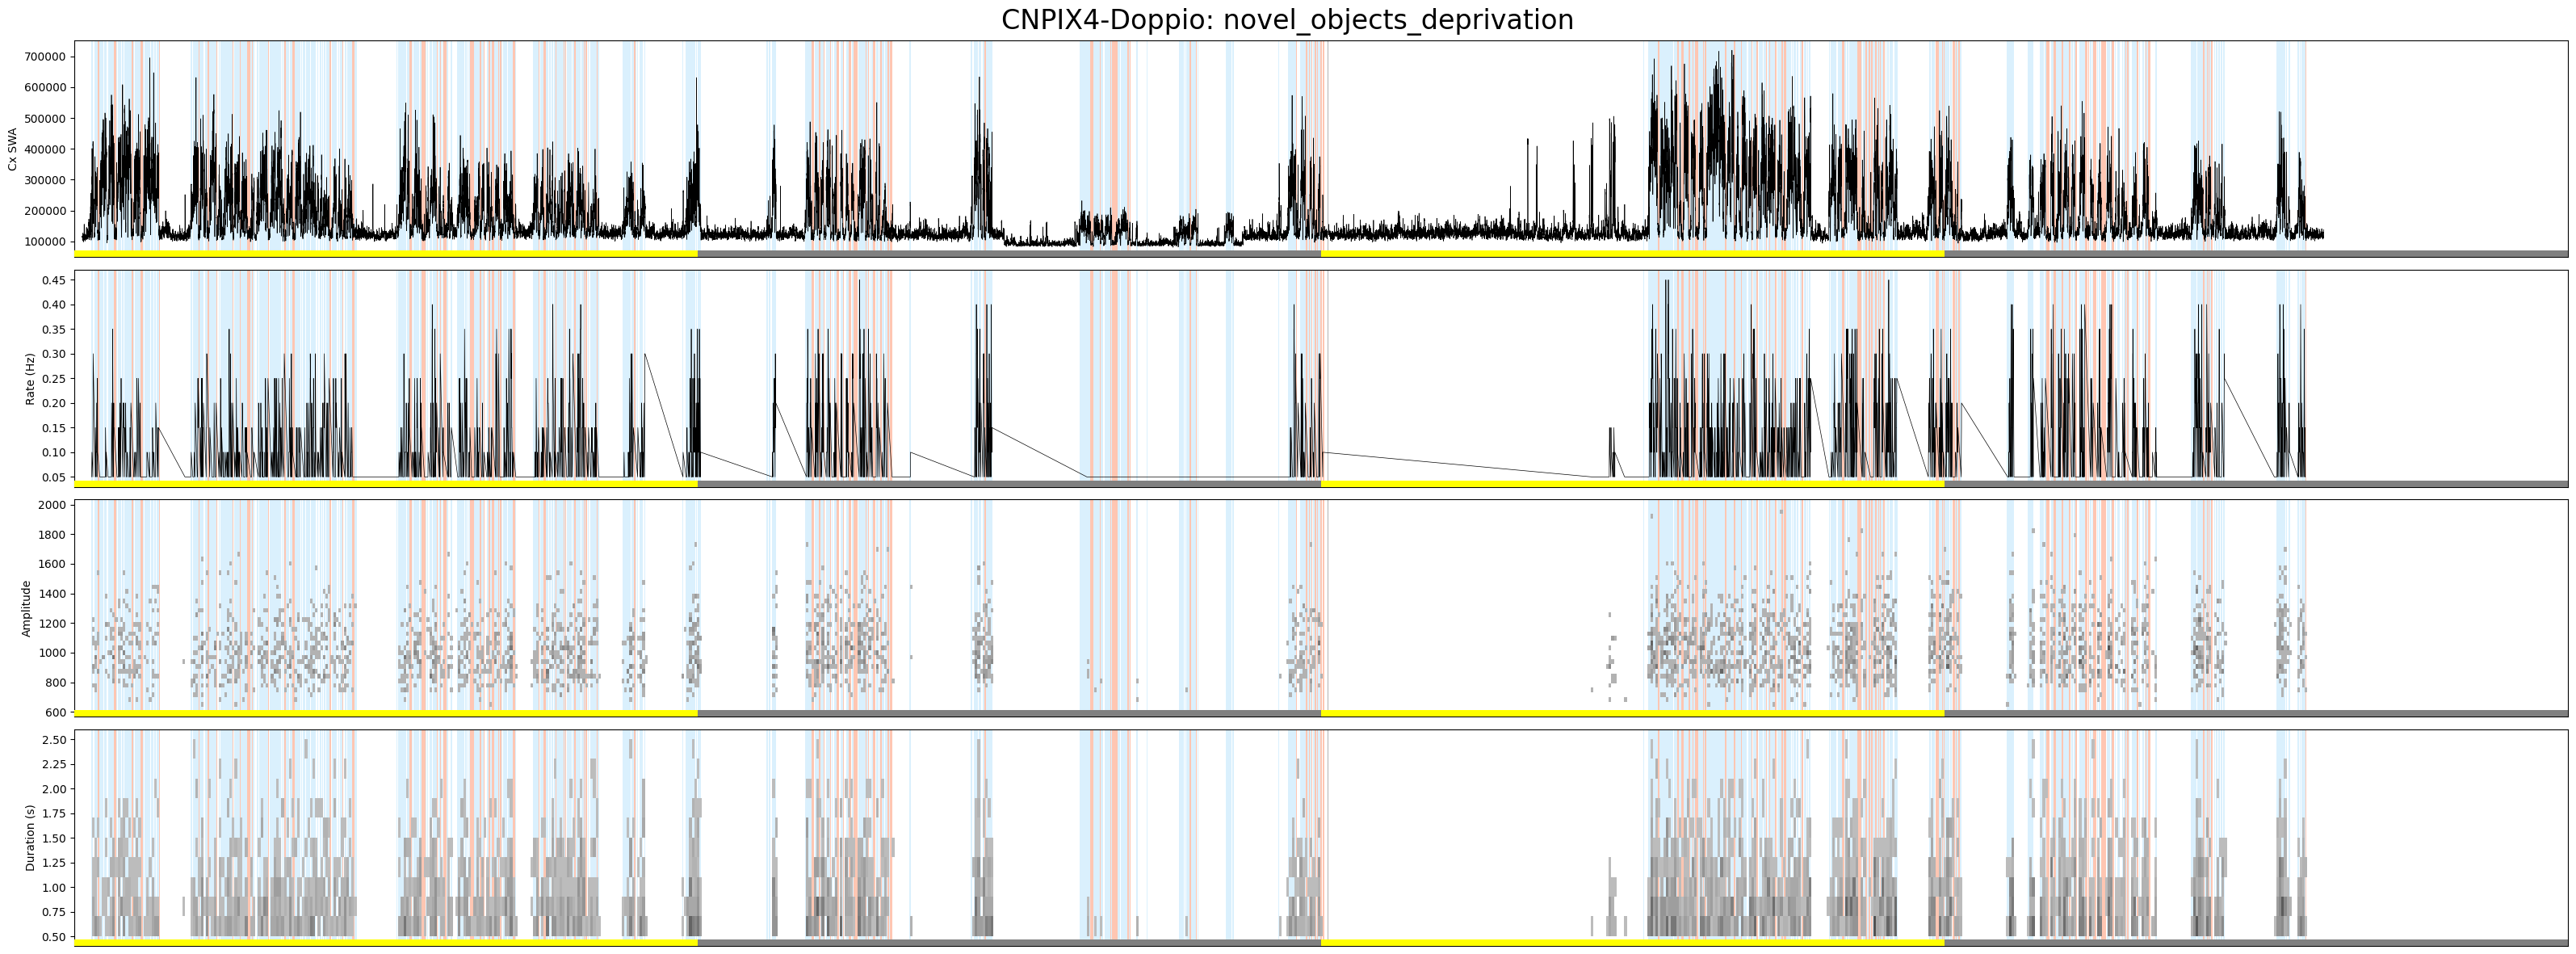

In [10]:
fig = sp.plot_spindle_timehist_summary(experiment, sglx_subject, cx_spindles)

Start           32315.476304
Peak            32315.628303
End             32316.596302
Duration            1.119999
Amplitude        1037.491278
RMS               210.899473
AbsPower            4.889037
RelPower            0.404127
Frequency          12.165168
Oscillations            13.0
Symmetry            0.134752
Stage                   NREM
Channel                  313
y                     6960.0
Name: 1035, dtype: object

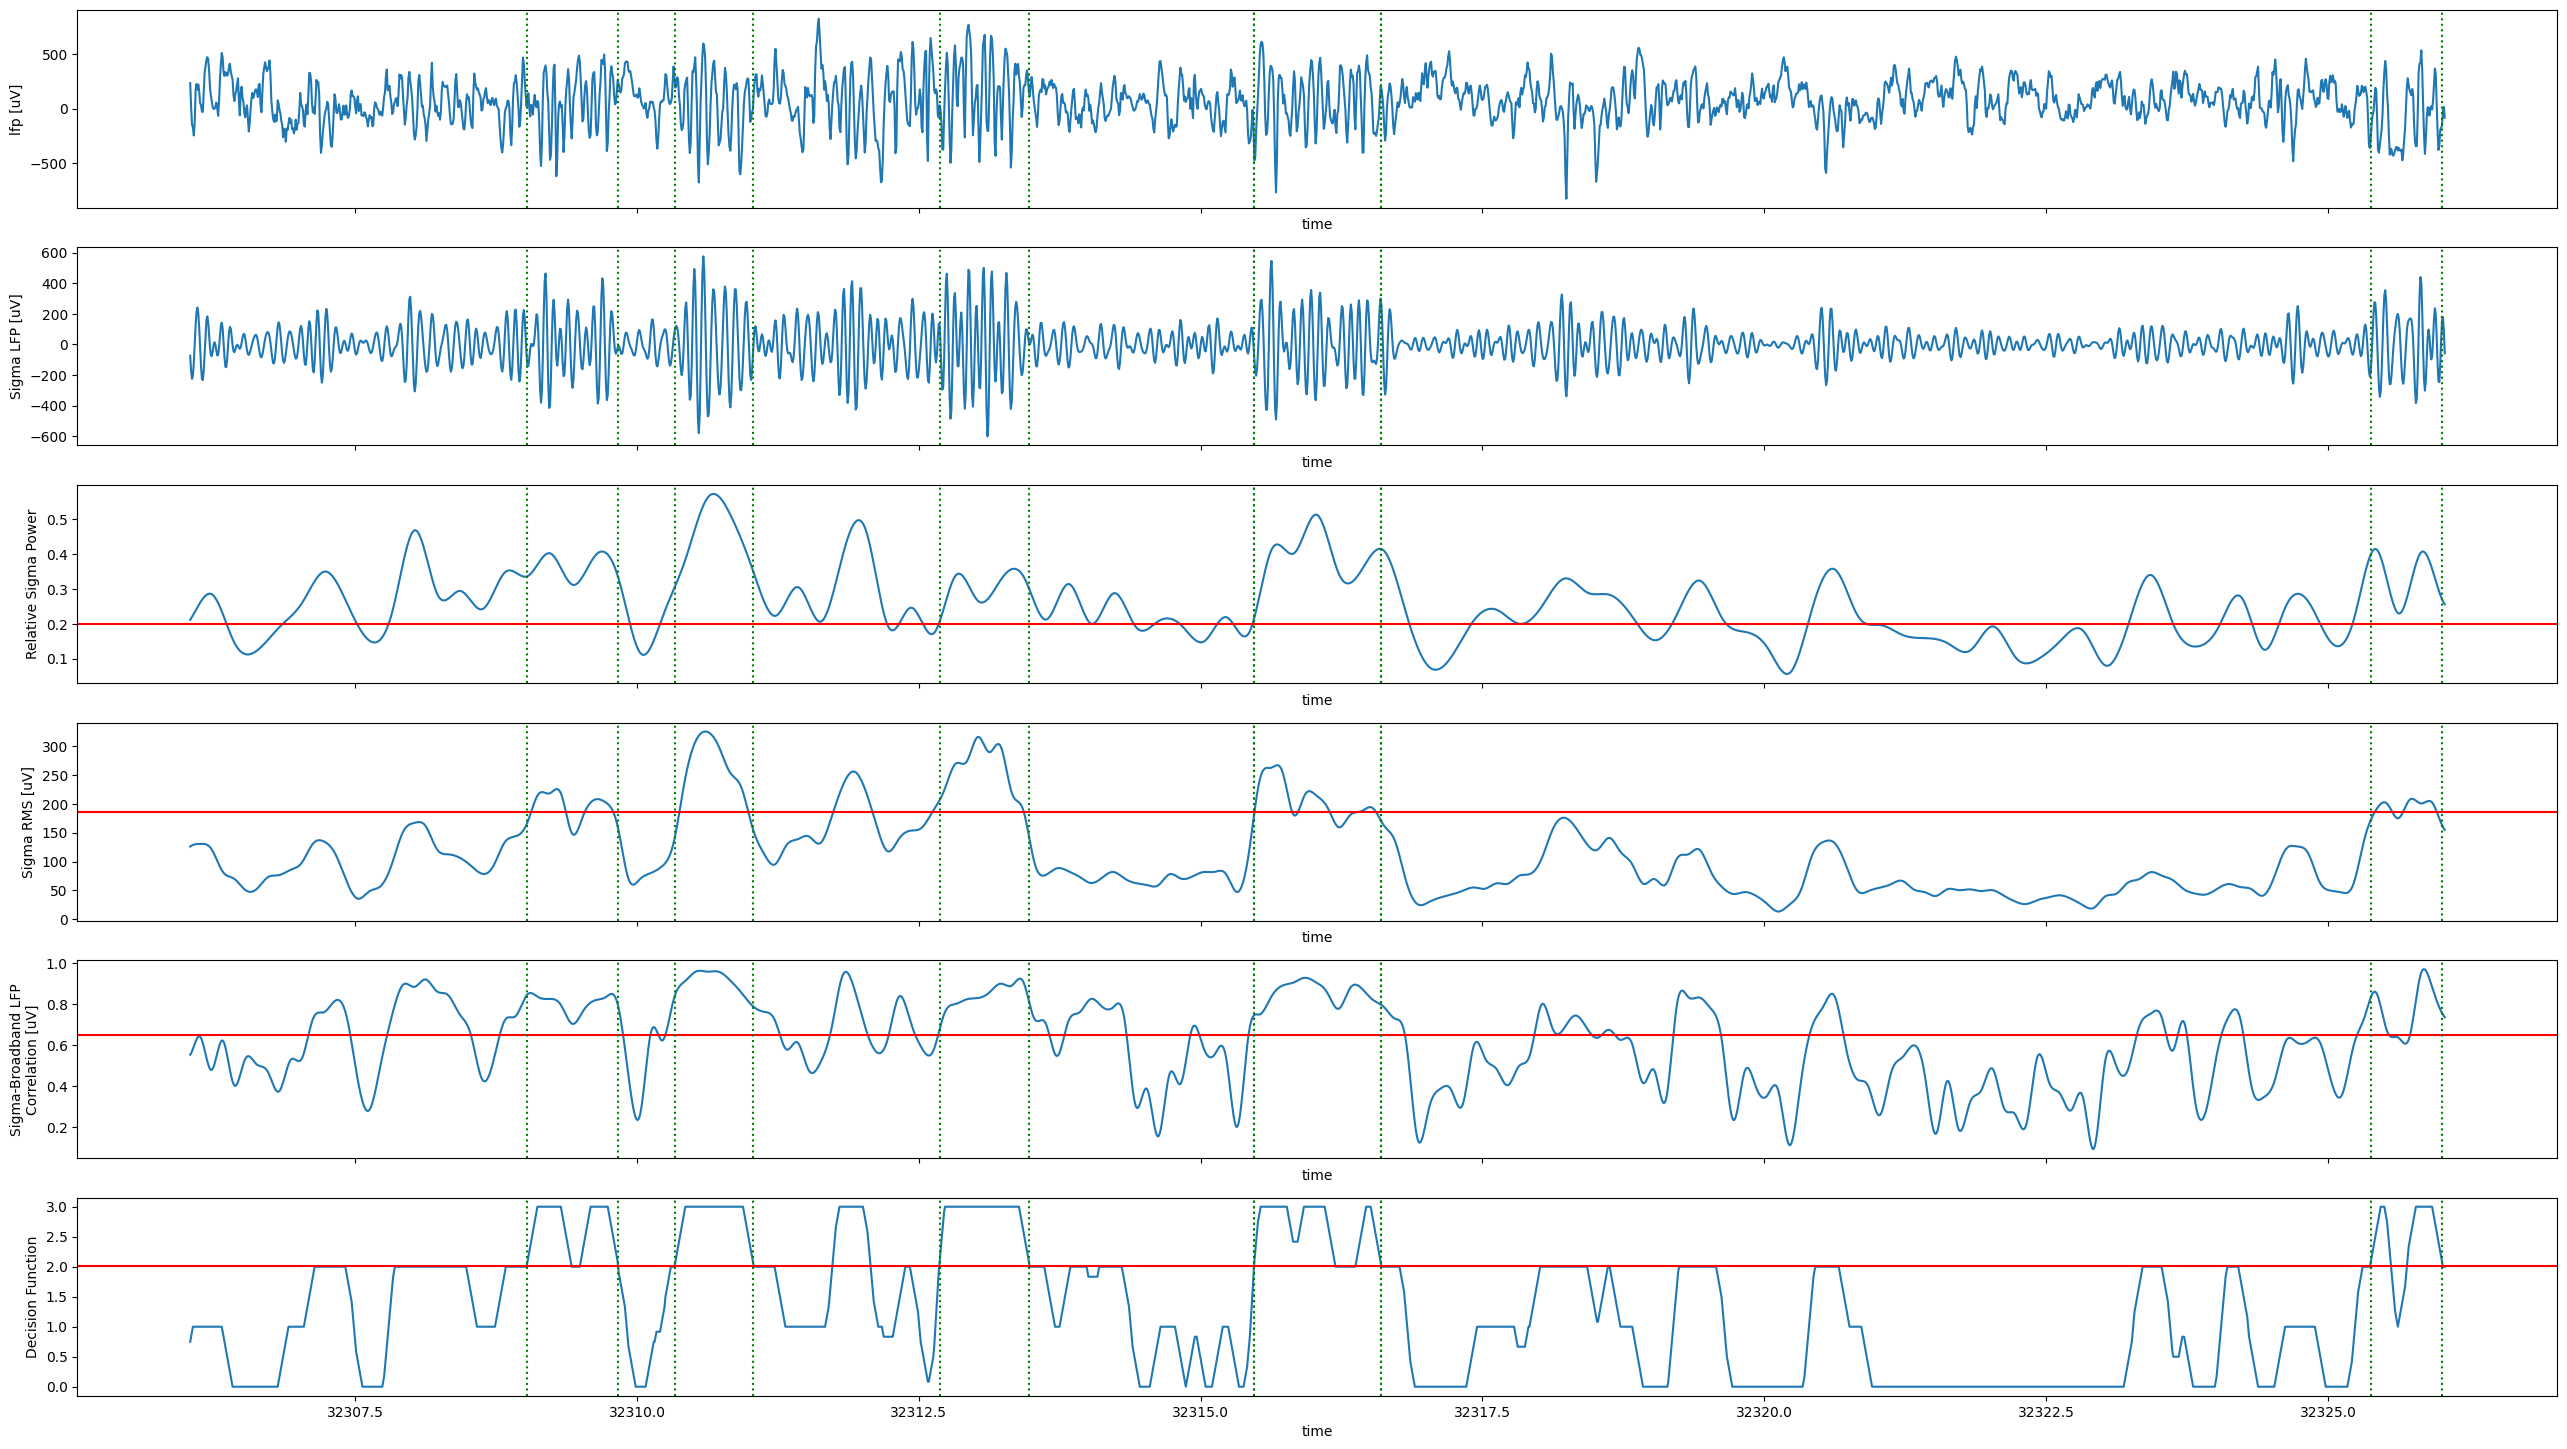

In [ ]:
sp.examine_spindle(
    cx_spindles,
    cx_chan_lf,
    cx_lf_sigma,
    cx_rpow,
    cx_mrms,
    cx_mcorr,
    cx_decision_function,
    params["relative_sigma_power_threshold"],
    cx_mrms_thresh,
    params["mcorr_threshold"],
    params["decision_function_threshold"],
    plot_duration=20,
)